# Ungraded Lab: ImageDataGenerator with a Validation Set

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Introduction_to_TensorFlow_for_Artificial_Intelligence_Machine_Learning_and_Deep_Learning/Week4/Labs/C1_W4_Lab_2_image_generator_with_validation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will continue using the `ImageDataGenerator` class to prepare the `Horses or Humans` dataset. This time, you will add a validation set so you can also measure how well the model performs on data it hasn't seen.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

Run the code blocks below to download the datasets `horse-or-human.zip` and `validation-horse-or-human.zip` respectively.

In [1]:
%%bash

mkdir data

# Download the training set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip -P ./data

# Download the validation set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip -P ./data

In [2]:
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras import Sequential, layers, Input, optimizers, utils, Model
import random

2024-06-10 17:04:46.309565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then unzip both archives.

In [3]:
# Unzip training set
local_zip = './data/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/horse-or-human')

# Unzip validation set
local_zip = './data/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/validation-horse-or-human')

zip_ref.close()

Similar to the previous lab, you will define the directories containing your images. This time, you will include those with validation data.

In [4]:
# Directory with training horse pictures
train_horse_dir = os.path.join('./data/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./data/horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./data/validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./data/validation-horse-or-human/humans')

Now see what the filenames look like in these directories:

In [5]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_names = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_names[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse31-0.png', 'horse43-3.png', 'horse40-7.png', 'horse20-0.png', 'horse46-2.png', 'horse09-6.png', 'horse29-2.png', 'horse43-0.png', 'horse08-7.png', 'horse48-1.png']
TRAIN SET HUMANS: ['human17-20.png', 'human08-08.png', 'human14-03.png', 'human05-14.png', 'human16-04.png', 'human03-30.png', 'human03-16.png', 'human13-14.png', 'human14-29.png', 'human17-11.png']
VAL SET HORSES: ['horse5-103.png', 'horse2-441.png', 'horse2-383.png', 'horse2-201.png', 'horse1-000.png', 'horse2-011.png', 'horse4-548.png', 'horse2-582.png', 'horse5-181.png', 'horse4-599.png']
VAL SET HUMANS: ['valhuman04-13.png', 'valhuman02-01.png', 'valhuman03-00.png', 'valhuman05-02.png', 'valhuman03-11.png', 'valhuman05-15.png', 'valhuman05-16.png', 'valhuman04-15.png', 'valhuman05-27.png', 'valhuman01-16.png']


You can find out the total number of horse and human images in the directories:

In [6]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [7]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

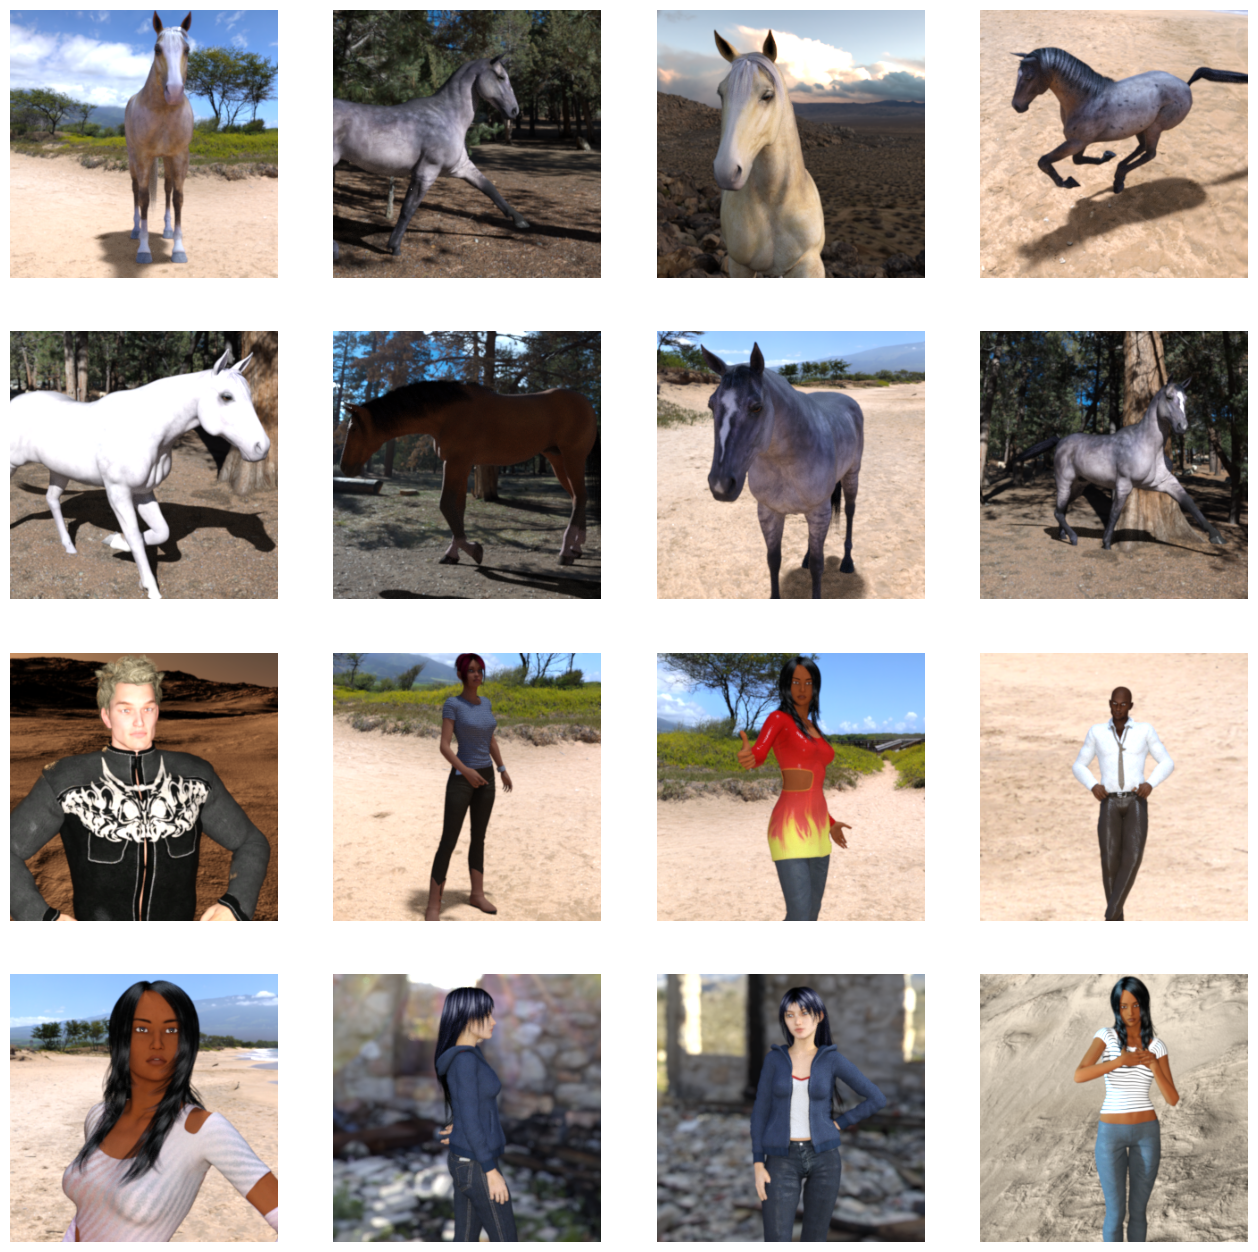

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[pic_index - 8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) for fname in train_human_names[pic_index - 8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

You will define the same model architecture as before:

In [9]:


model = Sequential([Input(shape=(300, 300, 3)),
                    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
                    # This is the first convolution
                    layers.Conv2D(16, (3, 3), activation='relu',),
                    layers.MaxPooling2D(2, 2),
                    # The second convolution
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The third convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The fourth convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The fifth convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # Flatten the results to feed into a DNN
                    layers.Flatten(),
                    # 512 neuron hidden layer
                    layers.Dense(512, activation='relu'),
                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
                    layers.Dense(1, activation='sigmoid')])

2024-06-10 17:04:49.256711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1896 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


You can review the network architecture and the output shapes with `model.summary()`.

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

You will also use the same compile settings as before:

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will setup the data generators. It will mostly be the same as last time but notice the additional code to also prepare the validation data. It will need to be instantiated separately and also scaled to have `[0,1]` range of pixel values.

In [12]:
# All images will be rescaled by 1./255
scale = layers.Rescaling(scale=1. / 255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = utils.image_dataset_from_directory(directory='./data/horse-or-human/',  # This is the source directory for training images
                                                     image_size=(300, 300),  # All images will be resized to 300x300
                                                     # batch_size=128,
                                                     # Since we use binary_crossentropy loss, we need binary labels
                                                     label_mode='binary')

# Flow validation images in batches of 128 using validation_datagen generator
validation_generator = utils.image_dataset_from_directory(directory='./data/validation-horse-or-human/',  # This is the source directory for validation images
                                                          image_size=(300, 300),  # All images will be resized to 300x300
                                                          # batch_size=32,
                                                          # Since you use binary_crossentropy loss, you need binary labels
                                                          label_mode='binary')

train_generator = train_generator.map(lambda image, label: (scale(image), label))
validation_generator = validation_generator.map(lambda image, label: (scale(image), label))

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


### Training
Now train the model for 15 epochs. Here, you will pass parameters for `validation_data` and `validation_steps`. With these, you will notice additional outputs in the print statements: `val_loss` and `val_accuracy`. Notice that as you train with more epochs, your training accuracy might go up but your validation accuracy goes down. This can be a sign of overfitting and you need to prevent your model from reaching this point.

In [13]:
history = model.fit(
                    train_generator,
                    # steps_per_epoch=8,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    # validation_steps=8
                    )

Epoch 1/15


I0000 00:00:1718060691.145915   31943 service.cc:145] XLA service 0x7f5f24005580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718060691.145944   31943 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-10 17:04:51.185033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 17:04:51.548023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4:28 8s/step - accuracy: 0.4062 - loss: 0.7010

I0000 00:00:1718060698.603705   31943 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.5766 - loss: 0.6859 - val_accuracy: 0.8086 - val_loss: 0.4849
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8527 - loss: 0.3460 - val_accuracy: 0.8672 - val_loss: 0.6042
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9400 - loss: 0.1595 - val_accuracy: 0.7656 - val_loss: 4.4386
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9637 - loss: 0.1228 - val_accuracy: 0.7305 - val_loss: 3.4393
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9732 - loss: 0.0973 - val_accuracy: 0.7891 - val_loss: 1.7890
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9578 - loss: 0.1492 - val_accuracy: 0.8477 - val_loss: 1.4407
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9714 - loss: 0.0975 - val_accuracy: 0.8750 - val_loss: 1.7173
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9790 - loss: 0.1465 - val_accuracy: 0.8711 - val_loss: 

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

If you're using Safari and the cell above throws an error, you will need to upload the images(s) manually in their workspace.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [14]:
%%bash

mkdir ./data/images
wget -q https://content.nationalgeographic.com.es/medio/2022/12/12/caballo-1_c26bdfb7_221212154643_1280x720.jpg -O ./data/images/horse.jpg

In [15]:
# CODE BLOCK FOR OLD VERSIONS OF SAFARI

images = os.listdir("./data/images")

print(images)

for i in images:
    print()
    # predicting images
    path = './data/images/' + i
    img = utils.load_img(path, target_size=(300, 300))
    x = utils.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])

    if classes[0] > 0.5:
        print(i + " is a human")
    else:
        print(i + " is a horse")

['horse.jpg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
[3.7790693e-18]
horse.jpg is a horse


### Visualizing Intermediate Representations

As before, you can plot how the features are transformed as it goes through each layer.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


/tmp/ipykernel_31729/2458107214.py:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_31729/2458107214.py:44: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


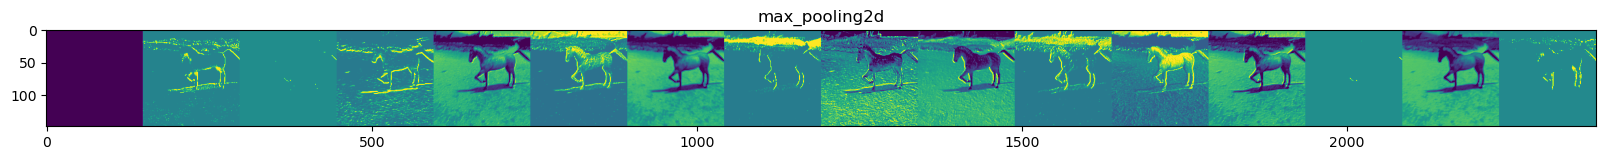

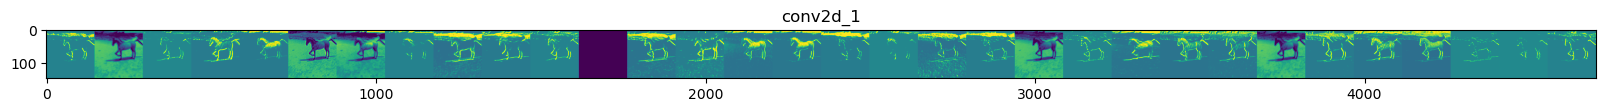

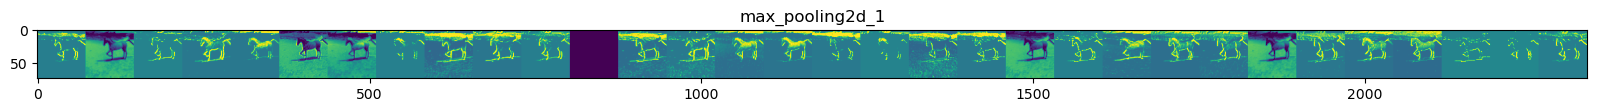

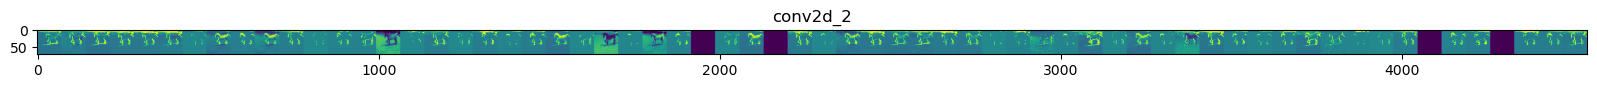

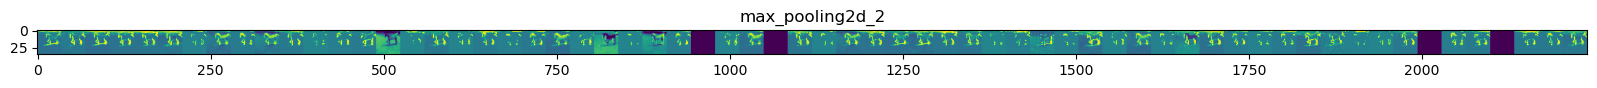

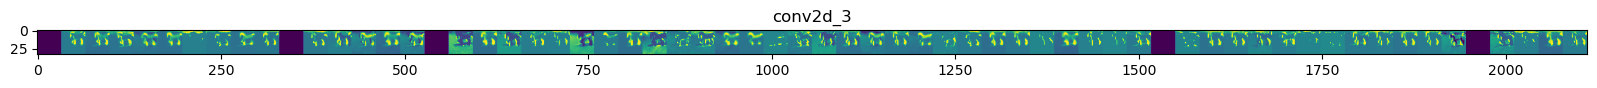

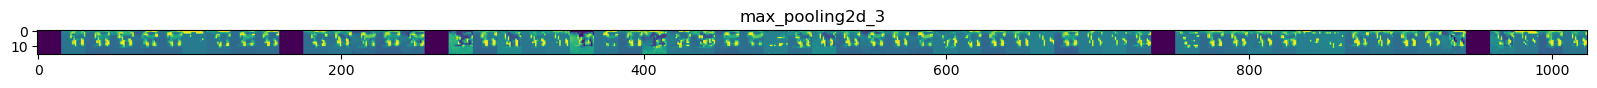

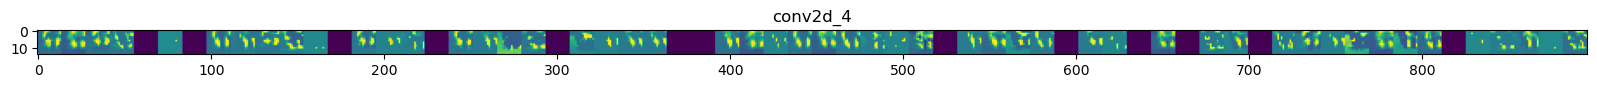

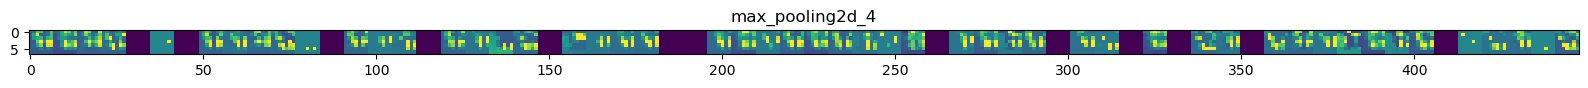

In [16]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputs=model.inputs, outputs=successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = utils.load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = utils.img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        
        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [17]:
!rm -rf ./data